In [6]:
%load_ext autoreload
%autoreload 2
import sys
import os
import copy
import math
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')  # noqa
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import model_utils
from abstract_gradient_training import privacy_utils

from models.fully_connected import FullyConnected

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
"""Set up environment, model, data and config for training."""

results_dir = ".results"
notebook_id = "gpt-2-imdb-privacy_results"
seed = 123
batchsize = 20000
torch.manual_seed(seed)
np.random.seed(seed)

# get dataset
X = np.load(".datasets/GPT2_IMDB_X_test.npy")
y = np.load(".datasets/GPT2_IMDB_Y_test.npy")
X_train = np.load(".datasets/GPT2_IMDB_X_train.npy")[10000 - 1 :]
y_train = np.load(".datasets/GPT2_IMDB_Y_train.npy")[10000 - 1 :]
X = np.concatenate((X, X_train), axis=0)
y = np.concatenate((y, y_train), axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True)
test_batch, test_labels = torch.from_numpy(x_test), torch.from_numpy(y_test)

nominal_config = AGTConfig(
    fragsize=5000,
    learning_rate=0.08,
    n_epochs=10,
    device="cuda:0",
    forward_bound="interval",
    backward_bound="interval",
    clip_gamma=0.1,
    early_stopping=False,
    loss="binary_cross_entropy",
    lr_decay=2.0,
    lr_min=0.001,
)
model = FullyConnected(in_dim=768, out_dim=1, hidden_lay=1, hidden_dim=100)
prior_acc = agt.test_metrics.test_accuracy(*model_utils.get_parameters(model), *next(iter(test_loader)))[1]

In [3]:
"""Complete all sweeps"""

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not config.k_unlearn
        np.random.seed(seed)
        torch.manual_seed(seed)
        param_l, param_n, param_u = agt.privacy_certified_training(
            model, config, train_loader, test_loader, transform=model_utils.propagate_conv_layers
        )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

conf = copy.deepcopy(nominal_config)
k_private = list(range(0, 101, 1))
privacy_results = {}

for k in k_private:
    print(f"\r{k}", end="")
    conf = copy.deepcopy(nominal_config)
    conf.k_private = k
    conf.log_level = "WARNING" if k > 0 else "DEBUG"
    privacy_results[k] = run_with_config(conf)

0

/tmp/ipykernel_3174576/2903635357.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_l, param_n, param_u = torch.load(fname)


100

In [8]:
def get_avg_sens(k_select, k_max_full):
    k_select = np.array(k_select)
    epsilon = 1.0
    delta = 10**-5
    beta = epsilon / (2 * math.log(2 / delta))
    # k_max = compute_max_certified_k(test_batch, test_labels, {k: privacy_results[k] for k in k_select[:-1]}).cpu().numpy()
    # smooth_sens = np.exp(-2 * beta * k_max)
    k_counts, k_bins = np.histogram(k_max_full, bins=k_select + 1)
    # assert np.allclose((np.exp(-2 * beta * (k_bins[:-1])) * k_counts).sum(), smooth_sens.sum())
    return (np.exp(-2 * beta * (k_bins[:-1])) * k_counts).sum() / len(k_max_full)


def get_good_spacing(start, k_max_full):
    """Compute a good set of k values using a greedy algorithm."""
    k_select = start
    N = len(k_select) - 2
    cur = 1
    it = 0
    same_count = 0
    best = get_avg_sens(k_select, k_max_full)
    while True:
        new = get_avg_sens(k_select, k_max_full)
        if new == best:
            same_count += 1
            if same_count > 4 * N:
                break
        else:
            same_count = 0
        best = min(best, new)
        # print(f"it: {it}, cur: {cur}, best: {best}, ks: {k_select}")
        # change the value of k_select at the current index in the direction of improvement
        if k_select[cur] + 1 == k_select[cur + 1]:
            right = np.inf
        else:
            right = get_avg_sens([k if i != cur else k + 1 for i, k in enumerate(k_select)], k_max_full)
            # print(f"right: {right}, {[k if i != cur else k + 1 for i, k in enumerate(k_select)]}")
        if k_select[cur] - 1 == k_select[cur - 1]:
            left = np.inf
        else:
            left = get_avg_sens([k if i != cur else k - 1 for i, k in enumerate(k_select)], k_max_full)
            # print(f"left: {left}, {[k if i != cur else k - 1 for i, k in enumerate(k_select)]}")
        if left < right and left < best:
            k_select[cur] -= 1
        elif right < new:
            k_select[cur] += 1
        else:
            cur = cur % (N) + 1
        it += 1
    # print(f"Final k_select: {k_select}, best: {best}")
    return k_select


res = []

k_max_full = privacy_utils.compute_min_uncertified_k(test_batch, test_labels, privacy_results).cpu().numpy()

res = []

start = np.linspace(0, 100, 10 + 2, dtype=int)
k_select = get_good_spacing(start, k_max_full)
print(k_select)

for N in range(98):
    start = np.linspace(0, 100, N + 2, dtype=int)
    k_select = get_good_spacing(start, k_max_full)
    sens = get_avg_sens(k_select, k_max_full)
    res.append(sens)

[  0   6  13  20  25  31  38  47  57  74  99 100]


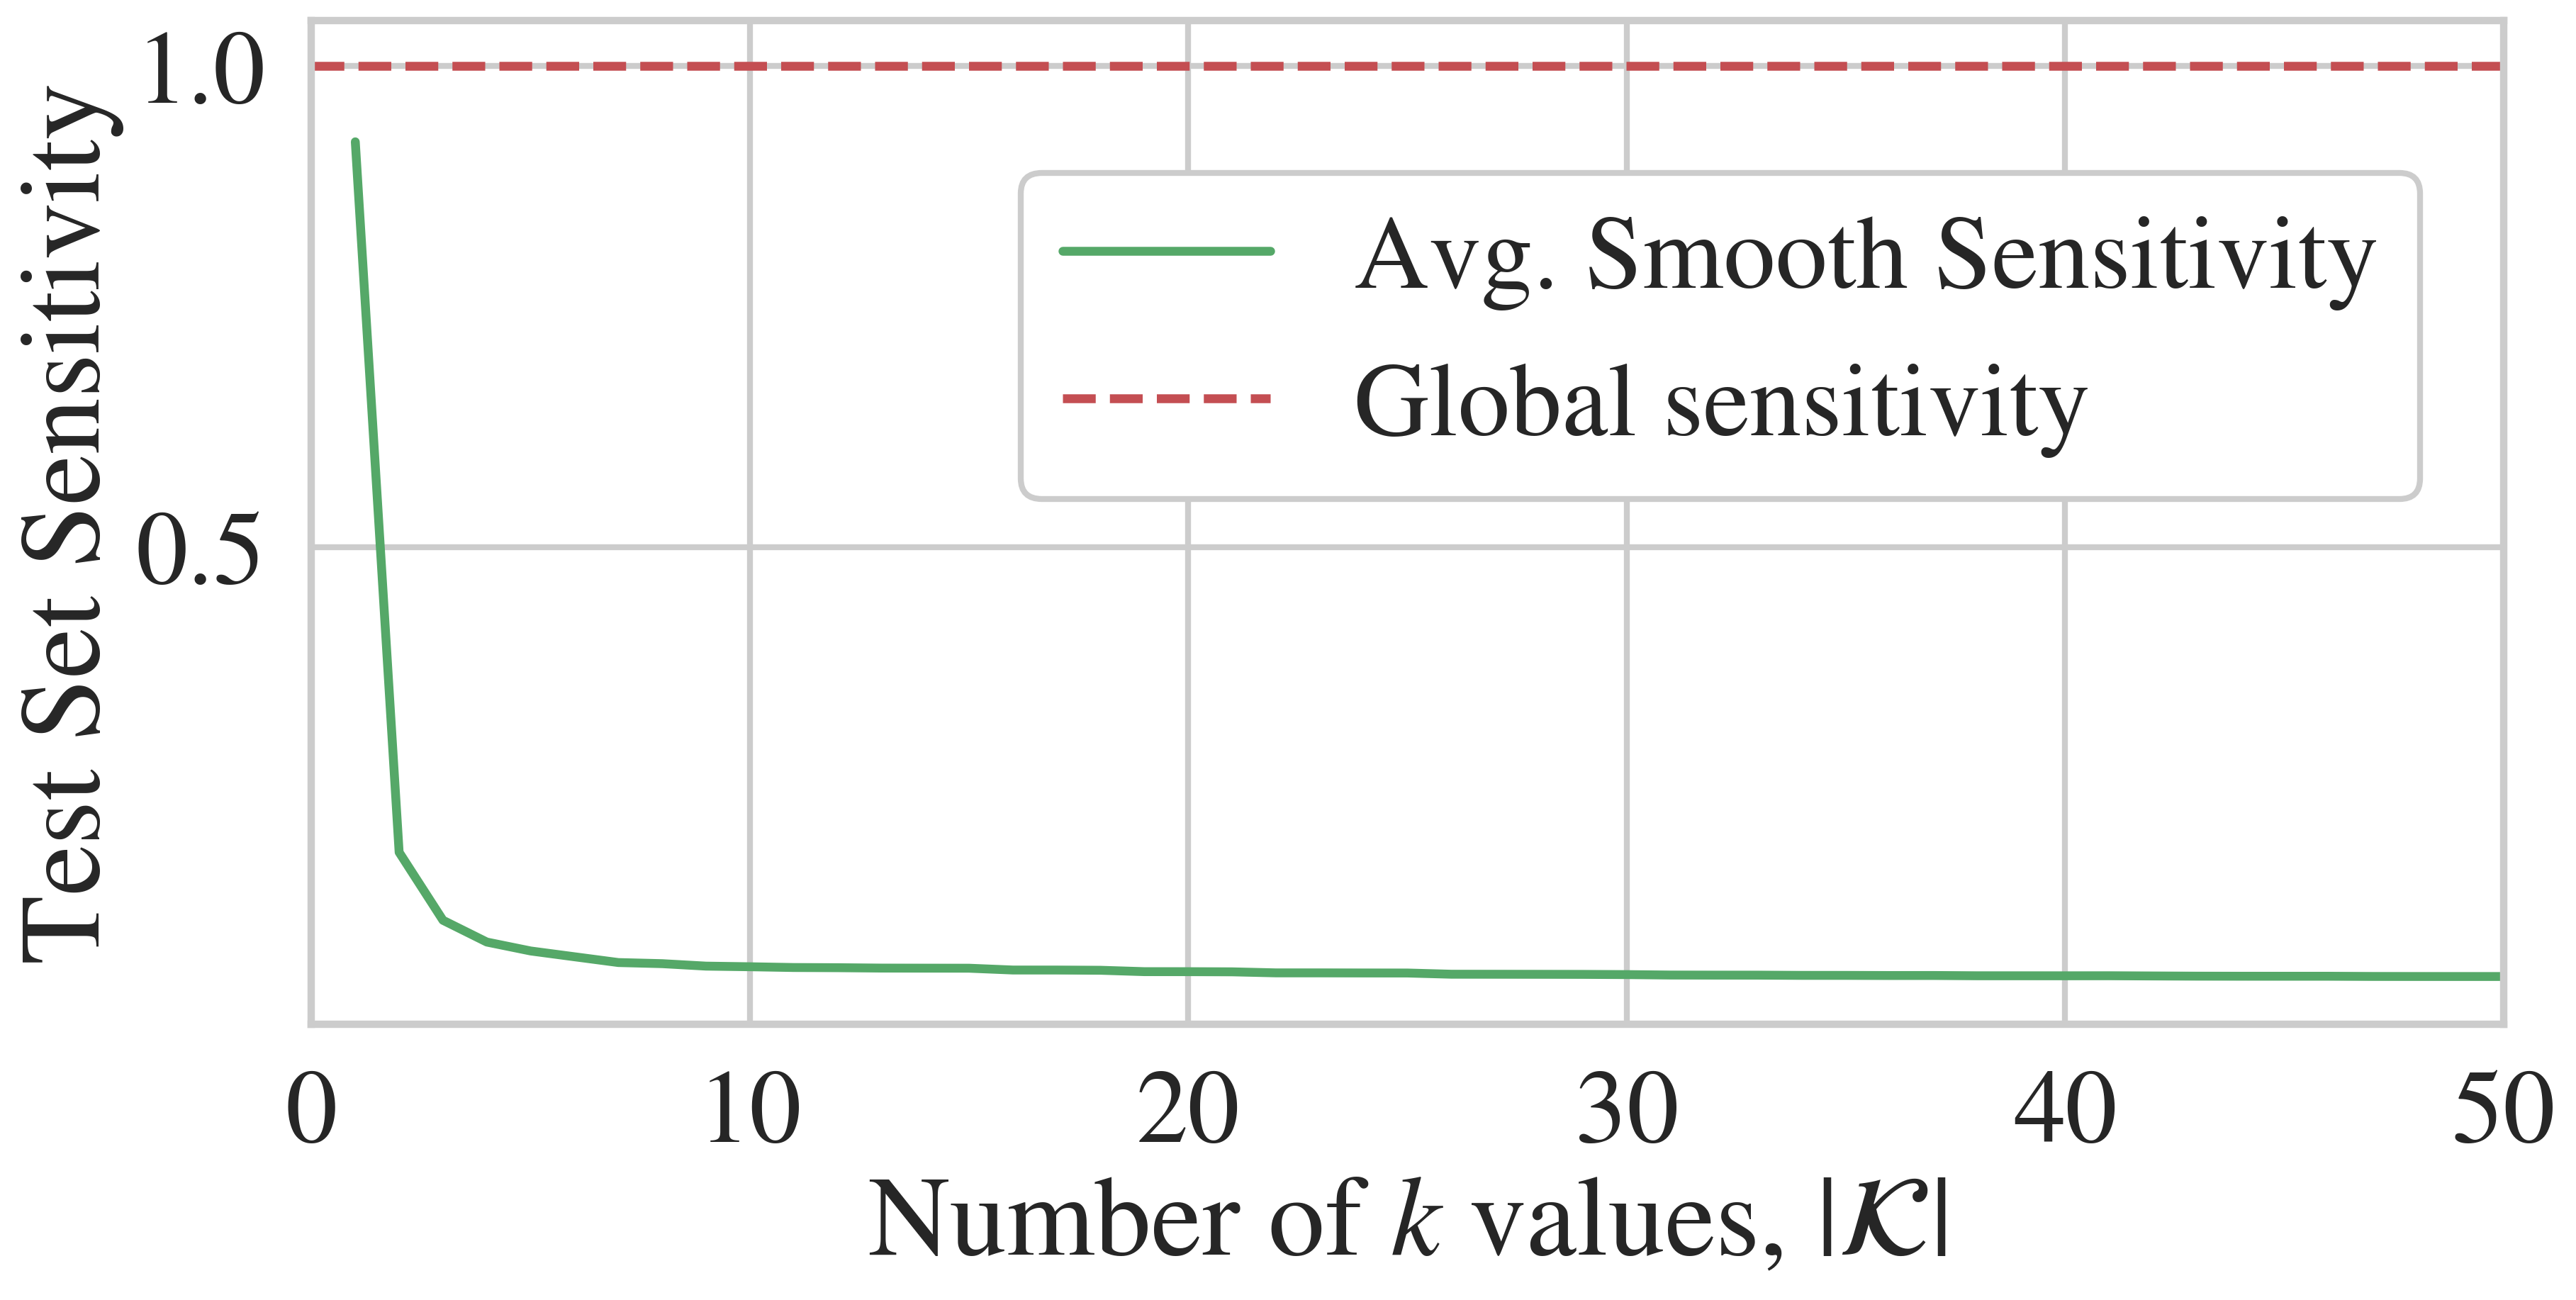

In [9]:
barcolor = sns.color_palette("deep")[0]
laplacecolor = sns.color_palette("deep")[3]
cauchycolor = sns.color_palette("deep")[2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.6)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

fig, axs = plt.subplots(1, 1, figsize=(12, 6), layout="constrained", sharex=True, dpi=300)
axs.plot(range(1, 99), res, color=cauchycolor, label="Avg. Smooth Sensitivity")
axs.axhline(1, color=laplacecolor, label="Global sensitivity", linestyle="--")
axs.set_ylabel("Test Set Sensitivity")
axs.set_xlim(0, 50)
axs.set_xlabel("Number of $k$ values, $|\mathcal{K}|$")
axs.legend(bbox_to_anchor=(0.3, 0.9), framealpha=1.0)
plt.savefig(".figures/num_k_values.pdf", bbox_inches="tight", dpi=300)